In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *

import matplotlib.pyplot as plt

## The autoencoding pipeline

We encode and decode back an image. 

In [3]:
# Load the model

device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


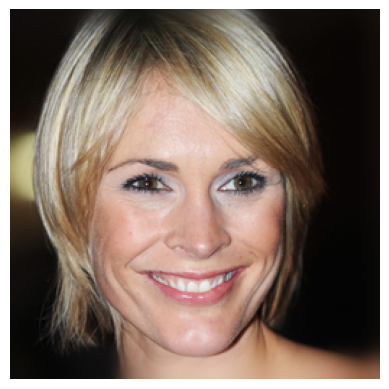

In [29]:
# Load the image

img_number = 1

data = ImageDataset('./imgs_align', image_size=conf.img_size, exts=['jpg', 'png'], do_augment=False)
batch = data[img_number]['img'][None]

def display_image(tensor, ax=None, rescale=False):
    tensor = tensor.cpu().permute([1, 2, 0])
    if rescale: tensor = (tensor + 1) / 2
    if ax is None:
        plt.axis("off")
        plt.imshow(tensor)
    else:
        ax.axis("off")
        ax.imshow(tensor)


# dataset images are in [-1, 1], they need to be rescaled to [0, 1]
display_image(batch[0], rescale=True)


In [30]:
# Encode the image into latent and stochastic space 

cond = model.encode(batch.to(device))

# T=250 takes 9s
xT = model.encode_stochastic(batch.to(device), cond, T=250)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


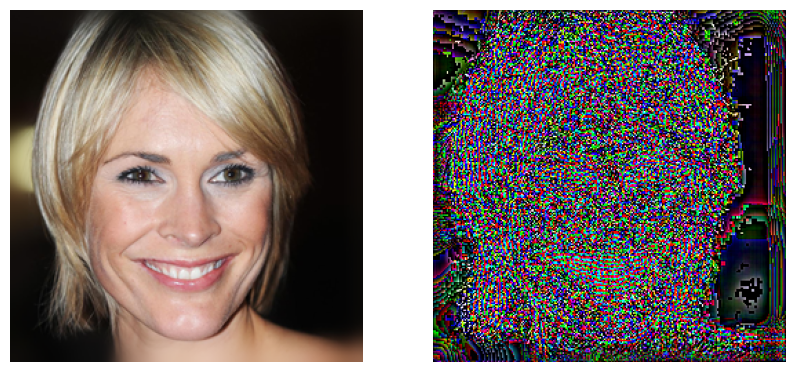

In [31]:
# Visualize the stochastic encoding

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
display_image(batch[0], ax[0], rescale=True)
display_image(xT[0], ax[1])


In [32]:
# Decode the image 

pred = model.render(xT, cond, T=20)

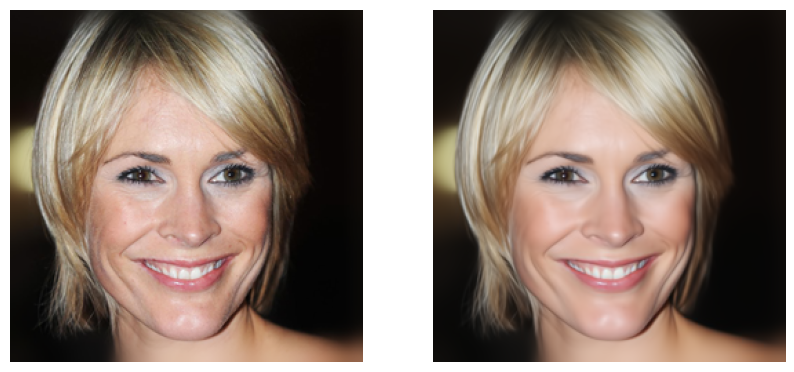

In [33]:
# Visualize the reconstruction

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
display_image(batch[0], ax[0], rescale=True)
display_image(pred[0], ax[1])


## Experiment 1: Random stochastic codes

How does autoencoding work when the denoising starts from a randomly sampled noise map?

In [34]:
# Encode the image to latent and stochastic codes
# Also sample random stochastic codes

cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

xT_random1 = torch.randn(size=(1,3,256,256)).to(device)
xT_random2 = torch.randn(size=(1,3,256,256)).to(device)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


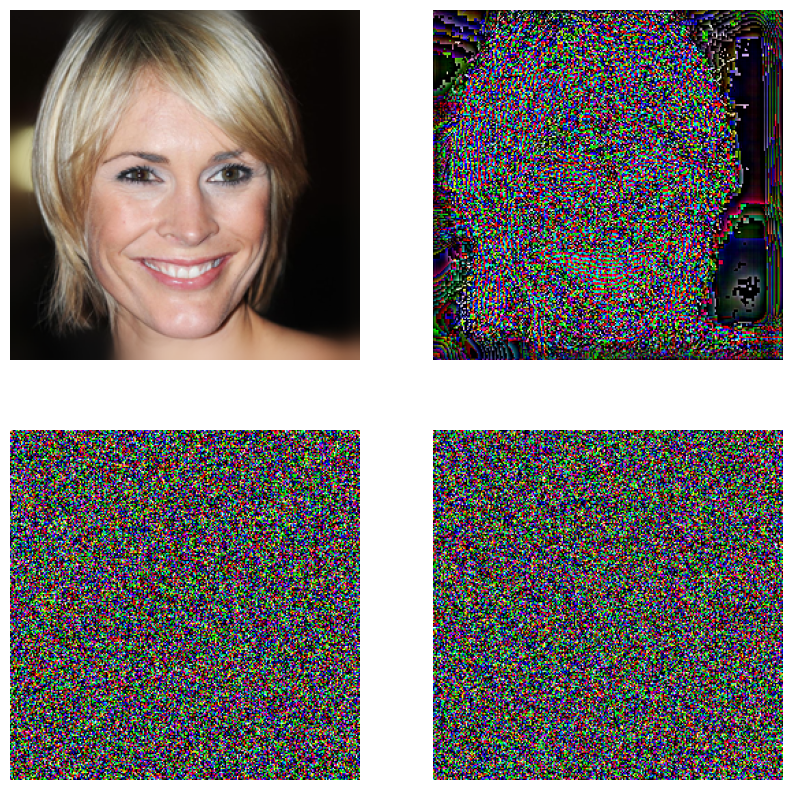

In [35]:
# Visualize the stochastic embeddings

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
display_image(batch[0], ax[0, 0], rescale=True)
display_image(xT[0], ax[0, 1])
display_image(xT_random1[0], ax[1, 0])
display_image(xT_random2[0], ax[1, 1])

In [36]:
# Decode the image 

pred = model.render(xT, cond, T=20)
pred_random1 = model.render(xT_random1, cond, T=20)
pred_random2 = model.render(xT_random2, cond, T=20)


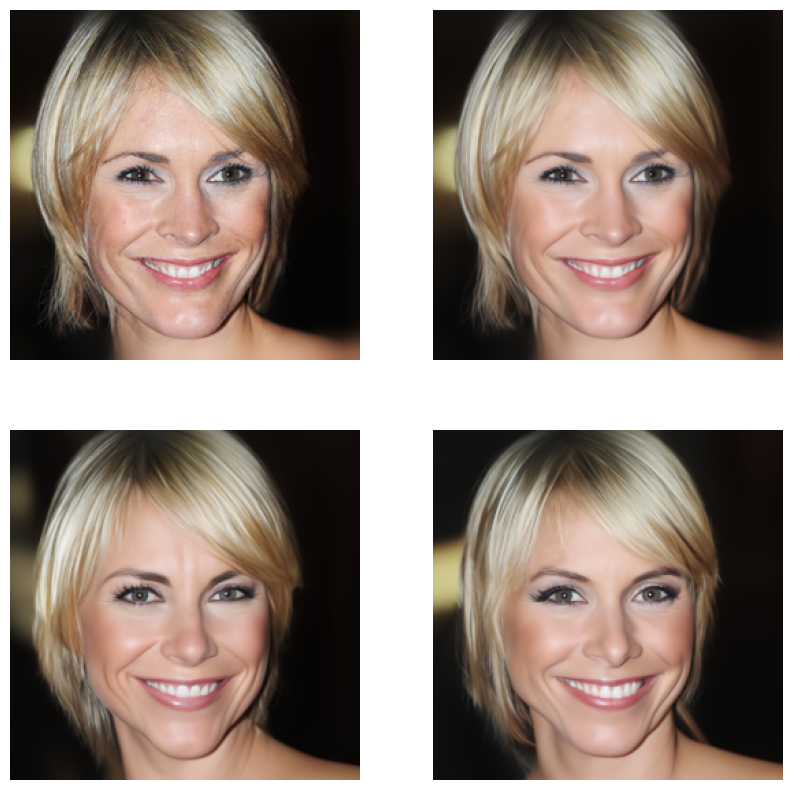

In [37]:
# Visualize the reconstructions

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
display_image(batch[0], ax[0, 0], rescale=True)
display_image(pred[0], ax[0, 1])
display_image(pred_random1[0], ax[1, 0])
display_image(pred_random2[0], ax[1, 1])

## Experiment 2: Number of timesteps in encoding and decoding

The `model.encode_stochastic()` and `model.render()` functions both support a parameter `T`. The models are trained `T_max = 1000`, i.e. the denoising involves 1000 steps without any skipping.
However, a simple optimization to improve the runtime is spaced diffusion. This involves doing multiple denoising steps in one go, i.e. directly predict x_{t-s} from x_{t}. 

For eg, if `T = 50`, then `s = 1000 / T = 20`. 

The parameters used by the authors are `T = 250` for encoding and `T = 20` for decoding. In this experiment we try other values. 

### Changing `T` in `encode_stochastic()`

In [38]:
# Encode the image to latent and stochastic codes
# Also sample random stochastic codes

cond = model.encode(batch.to(device))
xT50 = model.encode_stochastic(batch.to(device), cond, T=50)
xT250 = model.encode_stochastic(batch.to(device), cond, T=250)
xT1000 = model.encode_stochastic(batch.to(device), cond, T=1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


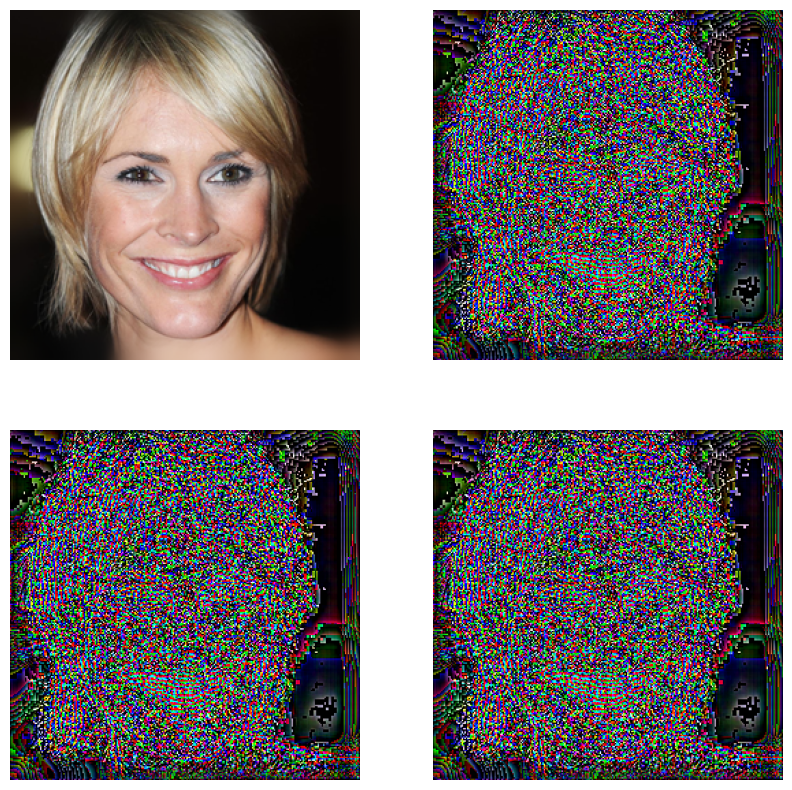

In [39]:
# Visualize the stochastic embeddings

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
display_image(batch[0], ax[0, 0], rescale=True)
display_image(xT50[0], ax[0, 1])
display_image(xT250[0], ax[1, 0])
display_image(xT1000[0], ax[1, 1])

In [40]:
# Decode the images 

pred50 = model.render(xT50, cond, T=20)
pred250 = model.render(xT250, cond, T=20)
pred1000 = model.render(xT1000, cond, T=20)


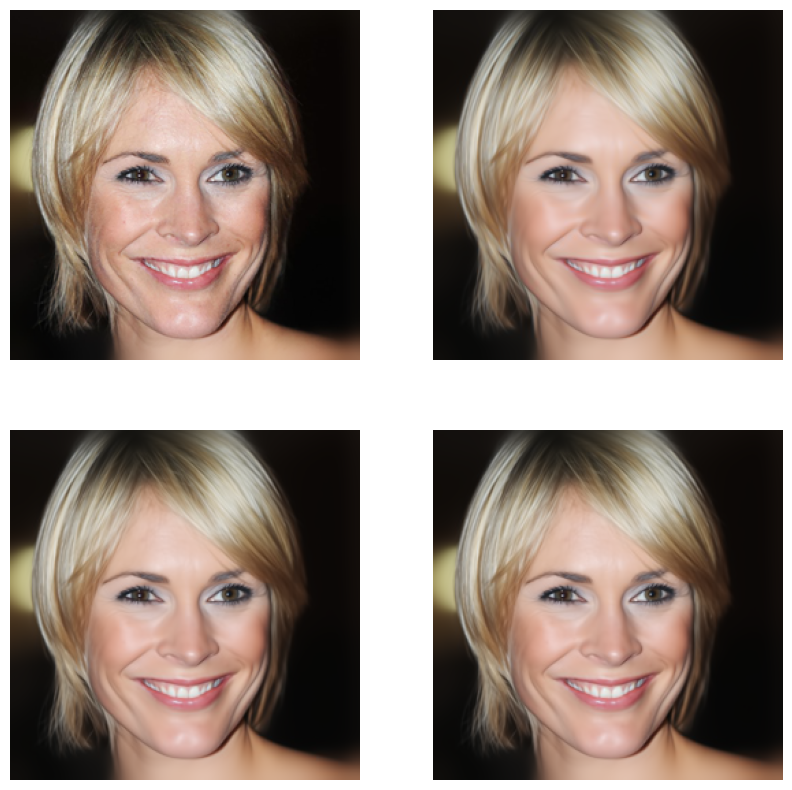

In [41]:
# Visualize the reconstructions

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
display_image(batch[0], ax[0, 0], rescale=True)
display_image(pred50[0], ax[0, 1])
display_image(pred250[0], ax[1, 0])
display_image(pred1000[0], ax[1, 1])

### Changing `T` in `render()`

In [42]:
# Encode the image to latent and stochastic codes
# Also sample random stochastic codes

cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

In [43]:
# Decode the images 

pred20 = model.render(xT, cond, T=20)
pred200 = model.render(xT, cond, T=200)
pred1000 = model.render(xT, cond, T=1000)


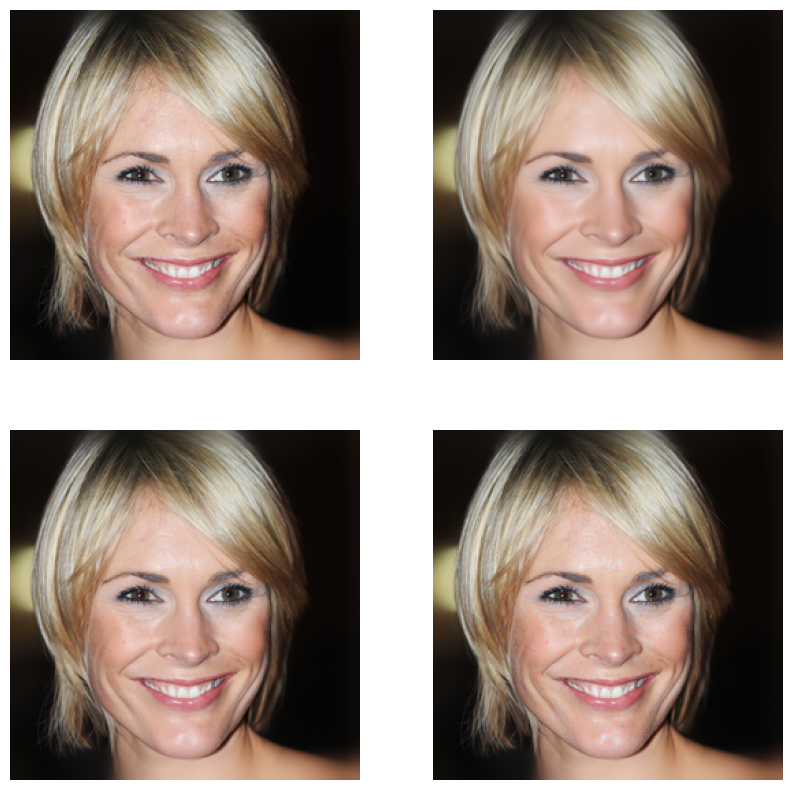

In [44]:
# Visualize the reconstructions

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
display_image(batch[0], ax[0, 0], rescale=True)
display_image(pred20[0], ax[0, 1])
display_image(pred200[0], ax[1, 0])
display_image(pred1000[0], ax[1, 1])